<a href="https://colab.research.google.com/github/pmgsalvado/Web-Scraping/blob/main/HouseWebScraping.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Web Scraping - Portuguese Apartment Renting WebSite - ImoVirtual</h1>
<p>Every time we need to proceed with websites scraping we must have a clear understanting of it's structure. We have to first analyse the site, identify where the information that we want to acquire, is. Then we have to find it on the HTML structure. For that we can use inspect (on Chrome).</p>
<p>We just have to right click of the website and click on inspect. A new window will open, with the HTML structure. In this windows we can check the tags, classes, id, etc. that we need to identify in order to fetch the data that we want</p>


In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd


<p>First we are going to check how many pages we need to go through to fetch all the ads.</p>
<p>For that we are going to retrive that number by "reading" the homepage of the website.</p>

In [2]:
# Read the home page.
# objecive: Find the total number of pages.
url = 'https://www.imovirtual.com/arrendar/apartamento/'
req1 = requests.get(url)
imo1 = BeautifulSoup(req1.text, 'html.parser')
number_pages = int(imo1.find_all('div', {'class': 'listing'})[0].find_all('ul', {'class': 'pager'})[0].find_all('li')[-2].string)
print(number_pages)

84


<p>The next step is to change the address page (url) to include each page on our analysis</p>
<p>Steps below. <u>This step may take a minute or so</u>.</p>

In [3]:
# create the variable that will take all html from each page
req_final = req1.text
# custom url. check that the link finishes with 'page=' for each page we are going to add the page number
# '...page=2' then '...page=3' and so on.
url_page = 'https://www.imovirtual.com/arrendar/apartamento/?page=' # + number of the page

for page in range(2,number_pages):
  url = url_page + str(page)
  req_tmp = requests.get(url)
  # if the request status is 200, everything went well and we add to the req_final each html structure
  if req_tmp.status_code == 200:
      req_final += req_tmp.text



<p>Each page, has a list of adds, that are inside a 'listing' tag. We must fetch for that tag.</p>
<p>Step below:</p>

In [4]:
# find listing tags for each page
imovirtual = BeautifulSoup(req_final, 'html.parser')
listing = imovirtual.find_all('div', {'class':'listing'})
len(listing)

83

<p>As we can see we have 83 "lists"</p>

<p>Next step, we are going to fetch all the adds (articles)</p>
<p>For each list in listing, we are going to place each add inside the articles list.</p>



In [5]:
articles = []
for list in listing:
  articles.extend(list.find_all('article'))

#len(listing[1].find_all('article'))

len(articles)

1992

In [6]:
house_dict = {'title': [], 'area': [],'typology': [],  'price': [],'Energy Efficiency': [], 'address': []} 
count=0
for article in articles:
  title = article.find('span', {'class' : 'offer-item-title'}).string
  area = article.find(class_='offer-item-area').string
  price = str(article.find('li',class_='offer-item-price').string).replace(' ', '').replace('\n', '')
  typology = article.find(class_='offer-item-rooms').string
  try:
    energy = article.find('div', {'class': 'energy-certify -c'}).string
  except:
    energy = 'nan'
  address_ = article.find('p', {'class': 'text-nowrap'})
  count = 0
  for address in address_.stripped_strings:
    if count > 0:
      address_f = address
    count += 1

  if len(typology.split()) == 0:
    house_dict['typology'].append('nan')
  else:
    house_dict['typology'].append(typology)

  if len(title.split()) == 0:
    house_dict['title'].append('nan')
  else: 
    house_dict['title'].append(title)
  if len(area.split()) == 0:
    house_dict['area'].append('nan')
  else:
    house_dict['area'].append(area)
  if len(price.split()) == 0:
    house_dict['price'].append('nan')
  else:
    house_dict['price'].append(price)
  if len(address.split()) == 0:
    house_dict['address'].append('nan')
  else:
    house_dict['address'].append(address_f)

  if len(energy.split()) == 0:
    house_dict['Energy Efficiency'].append('nan')
  else:
    house_dict['Energy Efficiency'].append(energy)

imovirtual_df = pd.DataFrame.from_dict(house_dict)

In [7]:
print(imovirtual_df['typology'].unique())
print(imovirtual_df['Energy Efficiency'].unique())


['T2' 'T1' 'T3' 'T0' 'T5' 'T4' 'T6' 'T9' 'T8' 'T10 ou superior']
['nan' 'C']


<p>Since much of the information is inserted by a person, some mistakes might occur</p>
<p>As we have seen, price, area, typology, energy efficiency, must have a specific structure, or elements common to each Ad:</p>
<ul>
  <li>price structure:  <b>€/mês</b></li>
  <li>area structure:  <b>m²</b></li>
  <li>Energy Efficiency:  <b>Letter from A to G -></b> <a href='https://www.unido.org/sites/default/files/2009-02/Module18_0.pdf'> Check this document page 20</a></li>
  <li>Typology:  <b>T[0-10+]</b></li>
<ul>
<br>
<p><u>For this analysis we'll use Regular Expressions</ul></p>

In [8]:
import re

In [9]:
def verify_structure(dataframe, col:str, structure: str):
  """
    This function will receive a dataframe, a column name and a structure to verify.
    If any row doesn't match that structure a 'nan' is added to that specific line of the columns being analyzed
  """
  for idx in dataframe.index:
    check = dataframe[col].iloc[idx]
    x = re.search(structure, check)
    if not(x):
      dataframe[col].iloc[idx] = 'nan'
  return dataframe

<p>Let's verify the price column</p>

In [10]:
imovirtual_df = verify_structure(imovirtual_df, 'price', '€/mês')

<p>Let's verify the area column</p>

In [11]:
imovirtual_df = verify_structure(imovirtual_df, 'area', 'm²')

<p>Let's verify the typology column</p>

In [12]:
imovirtual_df = verify_structure(imovirtual_df, 'typology', 'T[0-9]')

<p>LEt's verify Energy Efficiency</p>


In [13]:
imovirtual_df = verify_structure(imovirtual_df, 'Energy Efficiency', '[A-G]')

<h4>This step was not necessary, however to check for the coherence between the Title description and the select typology I decided to compare the description with the Tipology</h4>

<h5><b>For that, we'll use Regular Expressions to help with that</b></h5>
<h5><u>Regular Expression: </u></h5>
<ul>
  <li>re.findall(pattern, text)</li>
  <li>pattern to find: T[0-9]</li>
  <li> [0-9] - any value between 0 and 9 </li> 

</ul>

In [14]:
typology_check = []

for idx in imovirtual_df.index:
    text = imovirtual_df['title'].iloc[idx]
    x = re.findall('T[0-9]', text)
    if len(x) != 0:
      typology_check.append(x[0])
    else:
      typology_check.append('nan')

#change the order of the columns
new_cols_order = ['title', 'area', 'price', 'typology', 'typology_check','Energy Efficiency', 'address']
#add the list above to a new column
imovirtual_df['typology_check'] = typology_check
imovirtual_df= imovirtual_df[new_cols_order]

#imovirtual_df.head(10)

In [15]:
imovirtual_df['typology_check'].unique()

array(['T2', 'T1', 'T3', 'T0', 'nan', 'T5', 'T4', 'T6', 'T9', 'T8'],
      dtype=object)

<p>Since this dataframe is quite small we could easily see if we have any problem. However, for the sake, of "learning" let's find an automatic way to check if the values between the columns 'typology' and 'typology_check' match</p>

In [16]:
def check_different_values_and_correct(dataframe, col1: str, col2: str, col_priority: str):
  """
      This function, receives a dataframe, and two strings with the names of the columns to compare.
      It check 'line' by 'line' if the values of the two columns match. If yes don't do anything.
      If they are different, they are corrected.
      col_priority - > states the correct column, or the one that takes preference when it comes be more valuable and is the ony that is going
        to still remain on the dataframe, the other one will be removed. So condition col_pritority == col1 or col_priority == col2. otherwise error

      return: dataframe (corrected)
  """
  if col1 == col_priority or col2 == col_priority:
    col_stay = col_priority
    if col1 == col_priority:
      col_remove = col2
    elif col2 == col_priority:
      col_remove = col1

    list1 = list(dataframe[col1].values)
    list2 = list(dataframe[col2].values)

    no_match_idx = []
    if len(list1) != len(list2):
      print('Length of the lists doesn\'t match')
    else:
      for idx in range(len(list1)):
        if list1[idx] != list2[idx]:
          no_match_idx.append(idx)

    for idx in no_match_idx:
      if dataframe[col_stay].iloc[idx] == 'nan' and dataframe[col_remove].iloc[idx] != 'nan':
        dataframe[col_stay].iloc[idx] = dataframe[col_remove].iloc[idx]

    dataframe.drop(col_remove, axis=1, inplace=True)

    return dataframe
  else:
    print('Error: no matching columns')
    
  

In [17]:
imovirtual_df = check_different_values_and_correct(imovirtual_df, 'typology', 'typology_check','typology_check')


In [18]:
imovirtual_df['typology_check'].unique()

array(['T2', 'T1', 'T3', 'T0', 'nan', 'T5', 'T4', 'T6', 'T9', 'T8'],
      dtype=object)

In [19]:
imovirtual_df.rename(columns={'title': 'Description', 'area': 'Area (m²)', 'price': 'Price (€/month)', 'typology_check' : 'Typology', 'address': 'Address'}, inplace=True)
imovirtual_df.to_csv('/content/drive/MyDrive/Colab Notebooks/IBM Data Science doc/Python for Data Science/API - Websraping/Imovirtual.csv', index=False)

In [84]:
imovirtual_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/IBM Data Science doc/Python for Data Science/API - Websraping/Imovirtual.csv')

<p>Let's take a quick look at the dataframe</p>
<p>We have to make sure that Area (m²) and Price (€/month) have only </p>

In [86]:
imovirtual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Description        1992 non-null   object
 1   Area (m²)          1992 non-null   object
 2   Price (€/month)    1981 non-null   object
 3   Typology           1643 non-null   object
 4   Energy Efficiency  660 non-null    object
 5   Address            1992 non-null   object
dtypes: object(6)
memory usage: 93.5+ KB


<h1>Each time that we run the code we are going to find different apartments, since the webpage is always updating</h1>
<p>At this stage we are going to start working on the dataframe</p>
<p><b>The are a couple of operations that we still have to do to make this dataframe usable</b></p>
<ol>
  <li>convert Area and Price to floats</li>
  <li>Split the Adress to create a nue column with "City"</li>
</ol>

<p><b>1 - Convert Area and Price to float</b></p>

In [87]:
# ------------- 1 step ---------------------------------
# ------------- convert Area ---------------------------
# step to remove the m²
imovirtual_df['Area (m²)'] = imovirtual_df['Area (m²)'].str.replace('m²', '')
# in order to be able to convert string to float, we have to change the ',' with '.'
imovirtual_df['Area (m²)'] = imovirtual_df['Area (m²)'].str.replace(',', '.')
# convert to float
imovirtual_df['Area (m²)'] = imovirtual_df['Area (m²)'].astype('float')

# ------------- convert Price ---------------------------
# step to remove €/mês
imovirtual_df['Price (€/month)'] = imovirtual_df['Price (€/month)'].str.replace('€/mês', '')
# convert to float
imovirtual_df['Price (€/month)'] = imovirtual_df['Price (€/month)'].astype('float')
#imovirtual_df

<p><b>2 - Split Address and create new column with "City" - capital de distrito -(in Protugues)</b></p>
<p>If we analyse, the city, is always at the end of the string, so it will be easy to separate from the rest</p>
<p>We'll use .split(','). split the string by ',', it will create a list, and since it will always be the last element of the list we'll use list[-1], to grab the last element</p>

In [88]:
# we'll create a series, where each row will be a list from the split operation
addresses=imovirtual_df['Address'].str.split(',')
# after we'll add the city element to a new dictionary with key 'City' with a list
city = {'City': []}
for address in addresses:
  city['City'].append(address[-1])

city_df = pd.DataFrame.from_dict(city)

# now we'll add this dict to the existing dataframe - imovirtual_df
imovirtual_df = pd.concat([imovirtual_df, city_df], axis=1)
del city_df
#imovirtual_df

<h3>This is quite a simple dataframe. We'll just do some easy exploratory data analysis. The main purpose of this notebook was to show and test some webscraping and dealing with the data fetched.</h3>

In [89]:
imovirtual_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1992 entries, 0 to 1991
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Description        1992 non-null   object 
 1   Area (m²)          1992 non-null   float64
 2   Price (€/month)    1981 non-null   float64
 3   Typology           1643 non-null   object 
 4   Energy Efficiency  660 non-null    object 
 5   Address            1992 non-null   object 
 6   City               1992 non-null   object 
dtypes: float64(2), object(5)
memory usage: 109.1+ KB


<p>As we can see we have been able to convert the Area (m²) and Price to float and create a column for the City</p>

In [25]:
imovirtual_df.describe()

,Area (m²),Price (€/month)
count,1992.000000,1981.000000
mean,97.640999,3934.212014
std,52.072000,33715.171316
min,1.000000,50.000000
25%,65.000000,730.000000
50%,90.000000,950.000000
75%,120.000000,1500.000000
max,600.000000,690000.000000


<p>With describe method we can see some statistics of the numerical attributes</p>
<p>However in the dataframe we have several typologies, so we can't get much useful information by this</p>
<p>Let's dig in a little more...</p>
<br>
<p>Let's start by importing some libraries that might be usuful</p>

<p>Checking for duplicates.</p>

In [90]:
#imovirtual_df.loc[imovirtual_df.duplicated()]
print(f'Number of duplicates {imovirtual_df.duplicated().sum()}')

Number of duplicates 23


<p>We can see that we have some duplicates. Let's remove them from the dataframe</p>

In [91]:
imovirtual_df.drop_duplicates(inplace=True)
print(f'Number of duplicates {imovirtual_df.duplicated().sum()}')

Number of duplicates 0


<h2>At this stage, after making some preprocessing to the date fetched from the website we are able to start exploring the data and maybe draw some insights from it.</h2>
<p>note: each time we run we'll get different data, unless we use the saved file</p>

In [92]:
import matplotlib.pyplot as plt
import seaborn as sns


In [29]:
imovirtual_df.columns

Index(['Description', 'Area (m²)', 'Price (€/month)', 'Typology',
       'Energy Efficiency', 'Address', 'City'],
      dtype='object')

<h2>Let's start by some basic statistics</h2>
  <h3><b>Analysis of Price</b></h3>

In [93]:
imovirtual_df['Price (€/month)'].describe()

count      1958.00000
mean       3960.58427
std       33911.65536
min          50.00000
25%         730.00000
50%         950.00000
75%        1500.00000
max      690000.00000
Name: Price (€/month), dtype: float64

<p>We can clearly see that we have some outliers. The mean value is affected by each value in the dataset. However, since the value of the mean is so distante from the max, in this case we clearly see that we have outliers.</p>
<p>Let's just make a small plot to see the distribution by range of prices</p>

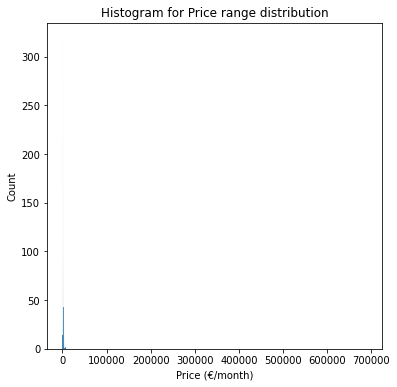

In [94]:
plt.figure(figsize=(6,6))
sns.histplot(data=imovirtual_df, x='Price (€/month)')
plt.title('Histogram for Price range distribution')
plt.show()

<p>In the website, we selected apartments to rent, however it seems that we are also getting some ads to buy houses, and we don't want that. So for that reason we bery high prices</p>
<p>It seems that this website doesn't distinguish between renting, selling, transfering a comercial space</p>
<p>So considering that we can buy/transfer space at starting from 15000€, let's remove rows with higher values than that. I think that a max renting price of 8000€</p>


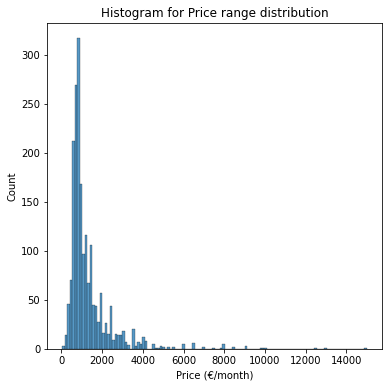

In [95]:
imovirtual_df_ = imovirtual_df.copy(deep=True)
imovirtual_df_.drop(imovirtual_df_.loc[imovirtual_df_['Price (€/month)']> 15000].index,axis=0, inplace=True)

plt.figure(figsize=(6,6))
sns.histplot(data=imovirtual_df_, x='Price (€/month)')
plt.title('Histogram for Price range distribution')
plt.show()

In [96]:
imovirtual_df.shape, imovirtual_df_.shape 

((1969, 7), (1953, 7))

In [75]:
#imovirtual_df_.loc[imovirtual_df_['Price (€/month)']> 8000]

In [97]:
imovirtual_df = imovirtual_df_

<p>As it was expected, this doesn't follow a normal distribution. Thus in order to identify and remove outliers from the dataset we'll use IQR method.</p>
<p>This states that an outlier is any values below the range of Q1 - 1.5* IQR and above Q3 + 1.5IQR</p>

In [98]:
def outlier_iqr(dataframe, col: str):
  Q1 = dataframe[col].quantile(0.25)
  Q3 = dataframe[col].quantile(0.75)
  #IQR = Q3 - Q1
  IQR = Q3 - Q1
  #print(Q1, Q3, IQR)
  #outlier = dataframe.loc[(dataframe[col]<(Q1 - 1.5*IQR) or dataframe[col] > (Q3 + 1.5*IQR))]
  print(f'Below: {(Q1 - 1.5*IQR)} \nAbove: {(Q3 + 1.5*IQR)}')
  outliers = dataframe[((dataframe[col] < (Q1 - 1.5*IQR)) | (dataframe[col] > (Q3 + 1.5*IQR)))]

  return outliers

In [99]:
outliers = outlier_iqr(imovirtual_df, 'Price (€/month)')

Below: -425.0 
Above: 2655.0


<p>After identifying the Outliers in price, we can check how many they are and then we can remove them from the dataframe</p>

In [100]:
print(f'We found {len(outliers)} in Price (€/month)')

We found 171 in Price (€/month)


<p>These values doesn't mean they are wrong. These could be houses in a very expensive part of town, maybe they have special features.</p> 

In [101]:
(outliers.index)

Int64Index([  14,   16,   25,   28,   47,   49,   57,   60,   65,   77,
            ...
            1073, 1084, 1091, 1283, 1309, 1358, 1543, 1567, 1591, 1657],
           dtype='int64', length=171)

<p>Next step, remove the outliers</p>

In [102]:
imovirtual_df.shape

(1953, 7)

In [103]:
imovirtual_df.drop(outliers.index, axis=0, inplace=True)
imovirtual_df.shape

(1782, 7)

 <p>Let's check the distribution of apartments by typology</p>

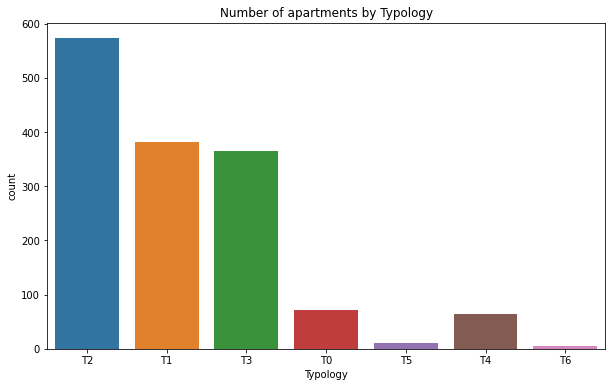

In [104]:
plt.figure(figsize=(10,6))
sns.countplot(data=imovirtual_df, x='Typology')
plt.title('Number of apartments by Typology')
plt.show()

<p>Let's show some boxplots to show the distribuition of prices by typology</p>

In [105]:
#imovirtual_df.head(10)

In [113]:
imovirtual_df=imovirtual_df.sort_values(by='Typology')


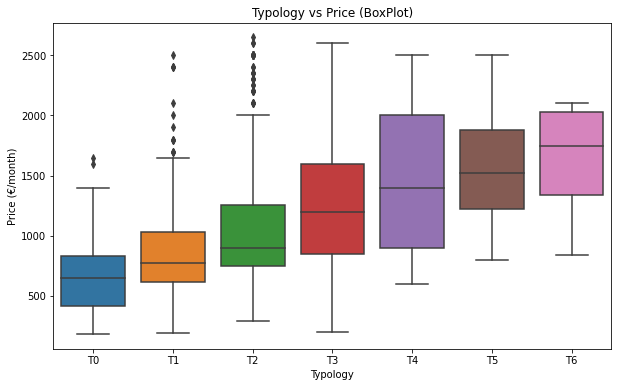

In [114]:
plt.figure(figsize=(10,6))
sns.boxplot(data=imvirtual_, x='Typology', y='Price (€/month)')
plt.title('Typology vs Price (BoxPlot)')
plt.show()

<p>With this graph we can see the variation of price for each typology.</p>
<p>We can also see that we have a linear relationship between the prices and the typology</p>

<h3>Analysis of Areas</h3>

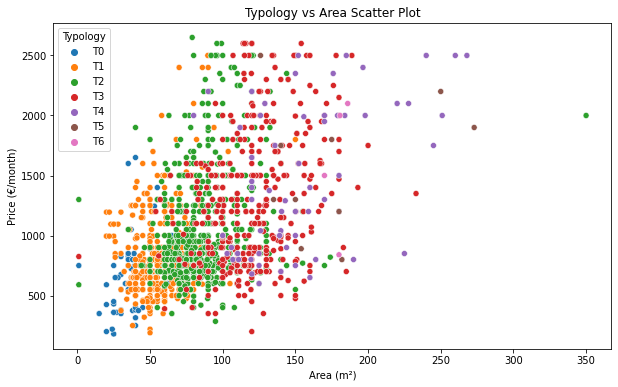

In [117]:
plt.figure(figsize=(10,6))
sns.scatterplot(data=imvirtual_, x='Area (m²)', y='Price (€/month)', hue='Typology')
plt.title('Typology vs Area Scatter Plot')
plt.show()

<p>We can't make a clear distinction or relation between the area and the renting price</p>
<p>However if we introduce a color component for the typology we see clusters</p>

<h2>Let's analyze the different reagions</h2>


In [118]:
cities = imovirtual_df['City'].unique()
cities

array([' Faro', ' Porto', 'Castelo Branco', ' Coimbra', ' Lisboa',
       ' Aveiro', ' Guarda', ' Setúbal', ' Castelo Branco', ' Braga',
       ' Santarém', ' Ilha da Madeira', ' Vila Real', ' Portalegre',
       ' Beja', ' Viana do Castelo', ' Leiria', ' Ilha de São Miguel',
       ' Viseu', 'Viseu', ' Ilha de Porto Santo', ' Évora', ' Bragança'],
      dtype=object)

<p>Let's compare de different areas in terms of max min mean renting prices</p>

In [135]:
stats = {'City': [], 'Max price': [], 'Min price': [], 'Average price': []}
for city in cities:
  stats['City'].append(city)
  stats['Max price'].append(imovirtual_df['Price (€/month)'].loc[imovirtual_df['City'] == city].max())
  stats['Min price'].append(imovirtual_df['Price (€/month)'].loc[imovirtual_df['City'] == city].min())
  stats['Average price'].append(imovirtual_df['Price (€/month)'].loc[imovirtual_df['City'] == city].mean())

stats_df = pd.DataFrame.from_dict(stats)
stats_df.sort_values(by='Average price',inplace=True,ascending=False)
#stats_df

print('Higher Max Min Average Prices')
print(f"Higher Average: {stats_df['Average price'].max()} - City: {stats_df['City'].loc[stats_df['Average price'] == stats_df['Average price'].max()].values}")
print(f"Higher Max Price {stats_df['Max price'].max()} - City: {stats_df['City'].loc[stats_df['Max price'] == stats_df['Max price'].max()].values}")
print(f"Higher Min Price {stats_df['Min price'].max()} - City: {stats_df['City'].loc[stats_df['Min price'] == stats_df['Min price'].max()].values}")

print('Lower Max Min Average Prices')
print(f"Higher Average: {stats_df['Average price'].min()} - City: {stats_df['City'].loc[stats_df['Average price'] == stats_df['Average price'].min()].values}")
print(f"Higher Max Price {stats_df['Max price'].min()} - City: {stats_df['City'].loc[stats_df['Max price'] == stats_df['Max price'].min()].values}")
print(f"Higher Min Price {stats_df['Min price'].min()} - City: {stats_df['City'].loc[stats_df['Min price'] == stats_df['Min price'].min()].values}")



Higher Max Min Average Prices
Higher Average: 1354.9290322580646 - City: [' Lisboa']
Higher Max Price 2650.0 - City: [' Lisboa']
Higher Min Price 550.0 - City: [' Ilha da Madeira']
Lower Max Min Average Prices
Higher Average: 390.0 - City: [' Portalegre']
Higher Max Price 450.0 - City: [' Ilha de Porto Santo']
Higher Min Price 50.0 - City: [' Leiria']


In [130]:
stats_df

,City,Max price,Min price,Average price
4,Lisboa,2650.0,60.0,1354.929032
11,Ilha da Madeira,2500.0,550.0,1250.000000
1,Porto,2500.0,250.0,1046.332530
21,Évora,2500.0,500.0,1035.714286
7,Setúbal,2500.0,360.0,928.125000
0,Faro,2000.0,350.0,891.817610
9,Braga,2500.0,300.0,879.473684
16,Leiria,1600.0,50.0,787.900000
5,Aveiro,1350.0,240.0,751.640625
3,Coimbra,1500.0,190.0,708.115942
